In [1]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel
from transformers import AutoTokenizer, CLIPTextModelWithProjection
from transformers import AutoProcessor, CLIPVisionModelWithProjection
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scipy.stats as st 
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import pickle
from sklearn.metrics.pairwise import pairwise_distances_argmin, pairwise_distances
import pandas as pd

In [2]:
def nearest_neighbors(x, self_is_neighbor = False):
    D = pairwise_distances(x, x, metric='cosine')
    if self_is_neighbor == False:
        np.fill_diagonal(D, np.inf)
    closest = np.argsort(D, axis=1)
    return closest

def mean_neighborhood_similarity(A, B, k):
    """
    This is $D_g(A, B, k)$
    """
    nx = nearest_neighbors(A)
    ny = nearest_neighbors(B)
    inter = 0
    for i in range(A.shape[0]):
        sx = set(nx[i, 0:k])
        sy = set(ny[i, 0:k])
        inter += len(sx.intersection(sy))/len(sx.union(sy)) # Jaccard distance
    inter /= A.shape[0]
    return inter

def mean_neighborhood_distance(A, B, k):
    """
    This is $D_g(A, B, k)$
    """
    inter = 1-mean_neighborhood_similarity(A,B,k)
    return inter

def mean_structural_distance(A, B):
    """
    This is $S_g(A, B)$
    """
    k_vals = np.array(list(range(1, A.shape[0]-1)))
    ns = np.array([mean_neighborhood_distance(A, B, k) for k in k_vals])
    
    msd = np.max((1-ns))
    return msd

In [3]:
n_samples = 100
dim = 50

In [4]:
snrs = [-40, -20, 0, 10, 30, 60] #Db
labels = [str(s) + ' dB' for s in snrs]
ks = range(1, n_samples)
curves = []
for snr in snrs:
    alpha = 10**(-snr/20)
    res = []
    for k in tqdm(ks):
        if k == 0:
            res.append(0)
            continue

        x = np.random.randn( n_samples, dim)
        y = x + alpha*(np.random.randn(n_samples, dim))       
        res.append(mean_neighborhood_similarity(x, y, k))
        
    curves.append(res)
curves=np.array(curves)

100%|██████████| 99/99 [00:00<00:00, 287.15it/s]


In [5]:
def make_curves(seed):
    snrs = [-40, -20, 0, 10, 30, 60] #Db
    labels = [str(s) + ' dB' for s in snrs]
    ks = range(1, n_samples)
    curves = []
    np.random.seed(seed)
    for snr in snrs:
        alpha = 10**(-snr/20)
        res = []
        for k in ks:
            if k == 0:
                res.append(0)
                continue

            x = np.random.randn( n_samples, dim)
            y = x + alpha*(np.random.randn(n_samples, dim))       
            res.append(mean_neighborhood_similarity(x, y, k))
            
        curves.append(res)
    curves=np.array(curves)
    return curves

from joblib import Parallel,delayed
all_curves = Parallel(n_jobs=-1)(delayed(make_curves)(n) for n in range(48*10))


In [6]:
curves = np.mean( all_curves, axis=0 )
curves.shape

(6, 99)

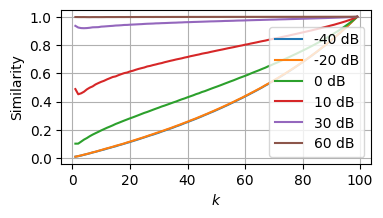

In [7]:

plt.figure(figsize=(4,2))

plt.plot(ks, curves.T, '-', label=labels)

plt.xlabel('$k$')
plt.ylabel('Similarity')
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.legend()
plt.savefig('dabk.pdf', bbox_inches='tight')


plt.show()

In [221]:
# Limit curve
ks = list(range(1, n_samples))
repetitions = 30

res = []
for k in tqdm(ks):
    this_res = []
    for r in range(repetitions):
        if k == 0:
            res.append(0)
            continue

        x = np.random.randn( n_samples, dim)
        y = np.random.randn(n_samples, dim)
        this_res.append(mean_neighborhood_similarity(x, y, k))
    res.append( np.mean(this_res) )
res = np.array(res)

100%|██████████| 99/99 [00:10<00:00,  9.58it/s]


In [ ]:
# Theoretical lower bound:
# Hypergeometrical distribution with:

# M = n_samples-1 objects (because a node is not a neighbor to itself)
# N = k objects of interest, but N <
# n = N draws

import scipy.stats as st
import matplotlib.pyplot as plt

M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

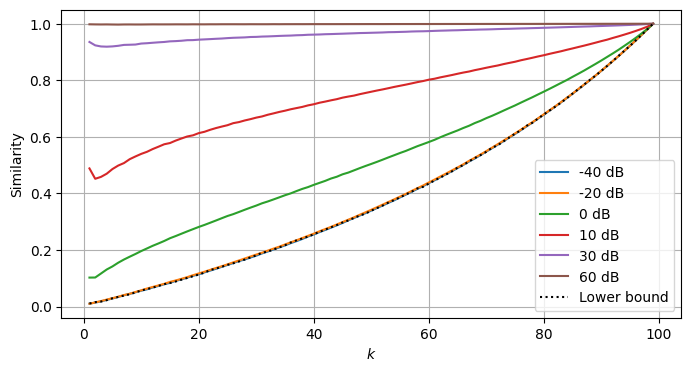

In [225]:
plt.figure(figsize=(8,4))
plt.plot(ks, curves.T, '-', label=labels)
plt.plot(ks, res, 'k:', label='Lower bound')
plt.plot(n,js, label='Lower bound (hypergeometric)')


plt.xlabel('$k$')
plt.ylabel('Similarity')
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.legend()
plt.savefig('dabk_lowerbound.pdf', bbox_inches='tight')


plt.show()

(6, 99)


/tmp/ipykernel_3276494/3199998045.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(ks, (np.array(curves).T - res_.T)/(1-res_.T), '-', label=labels)


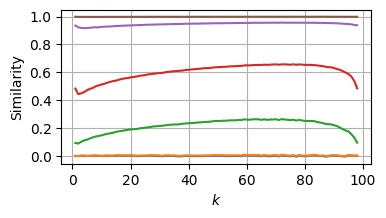

In [223]:
res_aux = res.reshape( (1,-1) )
res_ = np.repeat(res_aux,np.array(curves).shape[0],axis=0)
print(res_.shape)

plt.figure(figsize=(4,2))
plt.plot(ks, (np.array(curves).T - res_.T)/(1-res_.T), '-', label=labels)

plt.xlabel('$k$')
plt.ylabel('Similarity')
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.savefig('dabk_lowerbound_scaled.pdf', bbox_inches='tight')

plt.show()



# Impact of noise level

In [174]:
k = 20
snrs = np.linspace(-20, 60, 25)
alphas = np.sqrt( 10**(-snrs/10) )
res = []
for alpha in tqdm(alphas):
    argm = []
    A = np.random.randn( n_samples, dim)
    B = A + alpha*np.random.randn(n_samples, dim)
    s = mean_neighborhood_similarity(A, B, k)
    res.append(s)


100%|██████████| 25/25 [00:00<00:00, 318.16it/s]


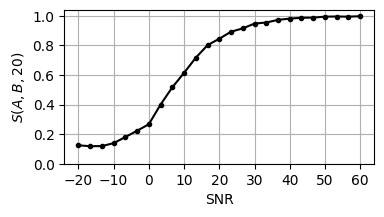

In [175]:
plt.figure(figsize=(4,2))
snrs = np.array(snrs)
res = np.array(res)
plt.plot(snrs, res,'.-k')
plt.xlabel('SNR')
plt.ylabel('$S(A,B,20)$')
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.xticks(range(-20, 61, 10))
plt.grid()
plt.show()

# Impact of n_samples

In [176]:
# argmin_k S(k) and min S(k) do not correlate with dimension (only in <10 dimensions)

snr = 0
alpha = 10**(-snr/20)
dim = 100
n_samples_list = np.array([5, 10, 20, 50, 100, 200])

res = {}

for n_samples in tqdm(n_samples_list):
    argm = []
    m = []

    for k in range(1, n_samples-1):
        x = np.random.randn( n_samples, dim)
        A = np.random.randn( n_samples, dim)
        B = A + alpha*np.random.randn(n_samples, dim)
        s = mean_neighborhood_similarity(A, B, k)     
        m.append(s)
    
    res[n_samples] = m



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


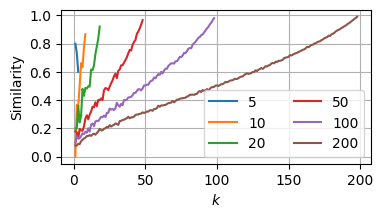

In [177]:
plt.figure(figsize=(4,2))
for n_samples in n_samples_list:
    ks = list( range(1, n_samples-1) )
    plt.plot(ks, res[n_samples], '-', label=str(n_samples))

plt.xlabel('$k$')
plt.ylabel('Similarity')
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.legend(ncol=2)
plt.grid()
plt.savefig('dabk_nsamples.pdf', bbox_inches='tight')
plt.show()

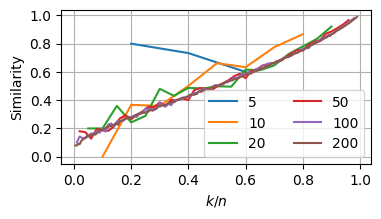

In [178]:
plt.figure(figsize=(4,2))
for n_samples in n_samples_list:
    ks = np.array(list( range(1, n_samples-1) ))
    plt.plot(ks/n_samples, res[n_samples], '-', label=str(n_samples))

plt.xlabel('$k/n$')
plt.ylabel('Similarity')
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.legend(ncol=2)
plt.grid()
plt.savefig('dabk_nsamples_normalized.pdf', bbox_inches='tight')
plt.show()

# Impact of dimensions

In [179]:
# argmin_k S(k) and min S(k) do not correlate with dimension (only in <10 dimensions)

snr = 0
alpha = 10**(-snr/20)
dims = list(range(2,100,1))
n_samples = 200
k = 20
res = []
argres = []
n_repeats = 30
rs = []
ps = []
for dim in tqdm(dims):
    argm = []
    m = []
   
    for n in range(n_repeats):
        x = np.random.randn( n_samples, dim)
        A = np.random.randn( n_samples, dim)
        B = A + alpha*np.random.randn(n_samples, dim)
        s = mean_neighborhood_similarity(A, B, k)     
        
        m.append(s)

    res.append(np.mean(m))
    

 93%|█████████▎| 91/98 [00:15<00:01,  5.90it/s]


KeyboardInterrupt: 

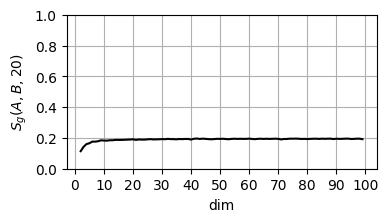

In [ ]:
plt.figure(figsize=(4,2))
plt.plot(dims, res, c='k')
corr, pval = st.pearsonr(res, dims)
plt.xlabel('dim')
plt.ylabel('$S_g(A, B, 20)$')
plt.xticks(range(0,110,10))
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.show()